<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>TF-IDF</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#DecisionTreeClassifier" data-toc-modified-id="DecisionTreeClassifier-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>DecisionTreeClassifier</a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-2.1.4"><span class="toc-item-num">2.1.4&nbsp;&nbsp;</span>LGBMClassifier</a></span></li></ul></li><li><span><a href="#BERT" data-toc-modified-id="BERT-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>BERT</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

In [ ]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [ ]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [ ]:
df['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

Наблюдаем дисбаланс класса в ваших данных. Т.к. наша метрика f1-оценка, она может быть полезна в случае классового дисбаланса. Проверим параметр class_weight .

In [ ]:
#Леммантизация
def lemmatize(text):
    m = WordNetLemmatizer()
    lemm_list = m.lemmatize(text)
    lemm_text = "".join(lemm_list)
    return lemm_text

In [ ]:
#Уберём лишние символы
def clear_text(text):
    
    return " ".join(re.sub(r'[^a-zA-Z ]',' ', text).split())

In [ ]:
df.loc[:, 'lemm_text'] = df['text'].apply(clear_text)

In [ ]:
df.loc[:, 'lemm_text'] = df['lemm_text'].apply(lemmatize)

In [ ]:
df

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m se...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...
...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,And for the second time of asking when your vi...
159567,You should be ashamed of yourself \n\nThat is ...,0,You should be ashamed of yourself That is a ho...
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,Spitzer Umm theres no actual article for prost...
159569,And it looks like it was actually you who put ...,0,And it looks like it was actually you who put ...


Разобьём данные на выборки.
Целевой признак это **toxic**. Если целевой признак категориальный, то решается задача классификации.

Признак для обудения модели: **lemm_text**.

In [ ]:
target = df['toxic']
features = df.drop("toxic", axis=1)

In [ ]:
# Разделение на обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target,
                                                                            stratify=target,
                                                                            test_size=0.25, 
                                                                            random_state=12345)

In [ ]:
target_train.value_counts()

0    107509
1     12169
Name: toxic, dtype: int64

In [ ]:
target_test.value_counts()

0    35837
1     4056
Name: toxic, dtype: int64

## Обучение

### TF-IDF

In [ ]:
corpus = features_train['lemm_text']
corpus_test = features_test['lemm_text']

In [ ]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

tf_idf = count_tf_idf.fit_transform(corpus) 
tf_idf_test = count_tf_idf.transform(corpus_test) 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
tf_idf_test.shape, tf_idf.shape

((39893, 142100), (119678, 142100))

In [ ]:
general_table = {}

#### LogisticRegression

In [ ]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight = 'balanced')
params = {
   'penalty':['l1', 'l2'],        
   'C':list(range(2,6,1))    
}

model_LogisticRegression = GridSearchCV(model, params, cv=3, scoring='f1', verbose=True).fit(tf_idf, target_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  1.1min finished


In [ ]:
model_LogisticRegression.best_params_

{'C': 5, 'penalty': 'l1'}

In [ ]:
predict = model_LogisticRegression.predict(tf_idf_test)
f1_score(predict, target_test)

0.7732674432286151

Логистическая регрессия с подобранными гиперпараметрами показывает хороший результат, F1=0.7732

In [ ]:
general_table.update({"LogisticRegression":f1_score(predict, target_test)})

#### DecisionTreeClassifier

In [ ]:
model = DecisionTreeClassifier(random_state = 12345, max_depth = 150)
params = {
    'criterion':['gini', 'entropy']
#    'max_depth':list(range(100,131,10))
}

model_DecisionTreeClassifier = GridSearchCV(model, params, cv=3, scoring='f1', verbose=True).fit(tf_idf, target_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  8.1min finished


In [ ]:
model_DecisionTreeClassifier.best_params_

{'criterion': 'gini'}

In [ ]:
predict = model_DecisionTreeClassifier.predict(tf_idf_test)

In [ ]:
f1_score(predict, target_test)

0.735235034150261

In [ ]:
general_table.update({"DecisionTreeClassifier":f1_score(predict, target_test)})

#### RandomForestClassifier

In [ ]:
model = RandomForestClassifier(random_state = 12345, class_weight='balanced')
params = {
#    'max_depth': list(range(30,70,10)),
#    'n_estimators': list(range(140,220,20)) 
    'max_depth': [60],
    'n_estimators':[140] 
}

model_RandomForestClassifier = GridSearchCV(model,params, cv=3, scoring='f1', verbose=True).fit(tf_idf, target_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.9min finished


In [ ]:
model_RandomForestClassifier.best_params_

{'max_depth': 60, 'n_estimators': 140}

In [ ]:
predict = model_RandomForestClassifier.predict(tf_idf_test)
f1_score(predict, target_test)

0.5044810167834447

In [ ]:
general_table.update({"RandomForestClassifier":f1_score(predict, target_test)})

#### LGBMClassifier

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
%%time
model = LGBMClassifier(learning_rate=0.3).fit(tf_idf, target_train)

CPU times: user 1min 23s, sys: 814 ms, total: 1min 24s
Wall time: 1min 25s


In [ ]:
predict = model.predict(tf_idf_test)
f1_score(predict, target_test)

0.7746674057649667

In [ ]:
predict = model.predict(tf_idf_test)
f1_score(predict, target_test)

0.7746674057649667

In [ ]:
general_table.update({"LGBMClassifier":f1_score(predict, target_test)})

Использовать кросвалидацию и перебирать параметры, очень долго. Необходим более мощный компьютер. LGBMClassifier с коробки справляется с поставленной задачей метрика больше 0.75.

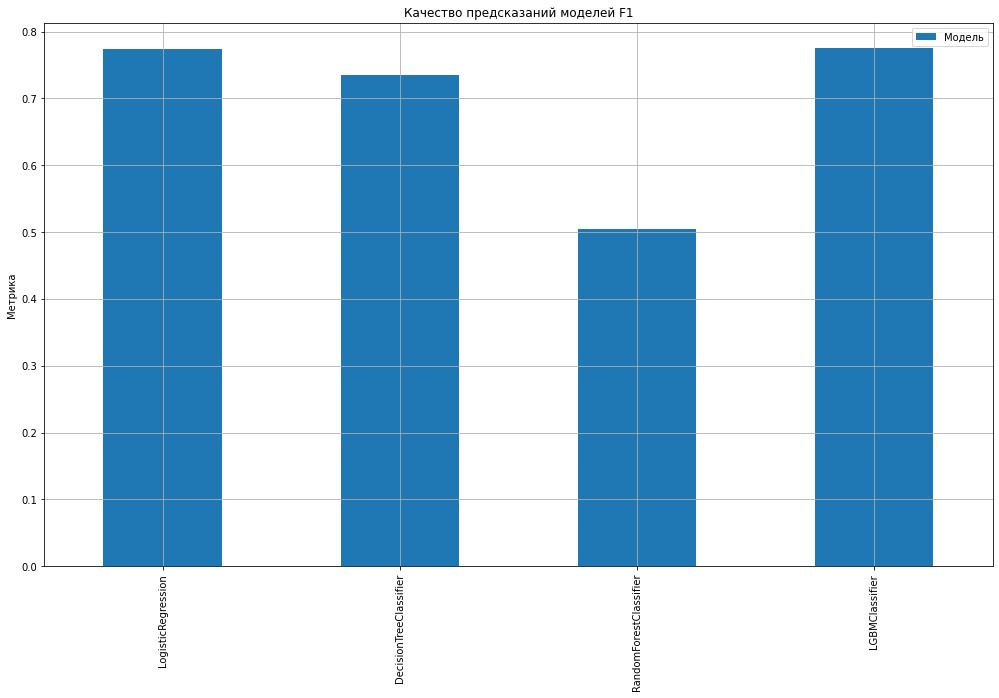

In [ ]:
pd.Series(general_table).plot(grid=True,figsize=(17, 10),kind='bar',label = 'Модель')
plt.title('Качество предсказаний моделей F1')
plt.ylabel('Метрика')
plt.legend()
plt.show()

Логистической регрессии и модель градиентного бустинга показывают хороший результат. У данных моделей F1 на тестовой выборке не падают ниже 0.75.

### BERT

Очень хотелось попробовать BERT, но не хватает мощности машины.

In [ ]:
# Зададим размер выборки. Ограничил количество записей. 
sample_size = 300

# Зафиксируем псевдослучайность
r_state=0
# Возьмём случайные объекты из корпуса
corpus_sample = df.sample(sample_size, random_state=r_state).reset_index(drop=True)
# Аналогично возьмём случайные ответы
target_sample = pd.Series(target_train).sample(sample_size, random_state=r_state).reset_index(drop=True)

In [ ]:
corpus_sample

,text,toxic,lemm_text
0,"""\nI haven't paraphrased you at all, Gary. Yo...",0,I haven t paraphrased you at all Gary You comp...
1,I BLOCKED REVERS! I BLOCKED REVERS! I BLOCKED ...,1,I BLOCKED REVERS I BLOCKED REVERS I BLOCKED RE...
2,I'm sorry. I'd like to unreservedly retract my...,1,I m sorry I d like to unreservedly retract my ...
3,I don't know if this is exactly like the Press...,0,I don t know if this is exactly like the Press...
4,"Thank you all, we'll all improve the Wikipedia...",0,Thank you all we ll all improve the Wikipedia ...
...,...,...,...
295,"Go away with your CIVIL stuff, mate. If you'd ...",0,Go away with your CIVIL stuff mate If you d ha...
296,Reliable sources \nWhen you remove Cosmo Lee's...,0,Reliable sources When you remove Cosmo Lee s r...
297,REDIRECT Talk:List of heads of government of A...,0,REDIRECT Talk List of heads of government of A...
298,"Yes, but this encyclopedia articles at their b...",0,Yes but this encyclopedia articles at their be...


In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
#максимально допустимое число токенов в модели BERT - 512, обрежем до 512.
tokenized = corpus_sample['lemm_text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation = True)))

In [ ]:
max_len=512
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

In [ ]:
input_ids = torch.tensor(np.array(padded))

In [ ]:
%%time
with torch.no_grad():
    last_hidden_states = model(input_ids)

CPU times: user 15min 8s, sys: 37.1 s, total: 15min 45s
Wall time: 15min 49s


In [ ]:
features = last_hidden_states[0][:,0,:].numpy()

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, target_sample)

In [ ]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
lr_clf.score(test_features, test_labels)

0.8933333333333333

## Выводы

Задачей было обучить модель, которая сумеет выявить токсичные комментарии. Подготовили текст, убрав из него все символы с помощью регулярных выражений и применив лемматизацию. Испытали TF-IDF подход к векторизации текстов. Удалось обучить модель Логистической регрессии и градиентного бустинга до необходимой метрики, F1 на тестовой выборке не падают ниже 0.75.

В качестве эксперимента мы обучили логистическую регрессию на эмбеддингах, полученных с помощью модели BERT. Всего 300 строк. 
BERT не работает с объектами длиннее 512 элементов. Часть данных могла потеряться. Генерация эмбеддингов занимает огромное количество времени и ресурсов.
